<a href="https://colab.research.google.com/github/redhyppo/MAIMLF2020/blob/master/LC2_2020_NB_GMM_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering con Gaussian Mixture Model applicato al dataset iris
da esempio originale di Oscar Contreras Carrasco

In [0]:
import numpy as np

import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
from PIL import Image
from sklearn.cluster import KMeans

**Iris dataset da scikit-learn**

Consiste in 150 istanze di Iris misurate da Edgar Anderson e classificate secondo tre specie: *Iris setosa*, *Iris virginica* e *Iris versicolor*. Le quattro variabili considerate sono la lunghezza e la larghezza del sepalo e del petalo

In [0]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
#stampa efeature reative ai primi 20 eventi del dataset
X[:20]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3]])

**Parte 1: implementazione "a mano" del modello**

Gaussian density function (può essere fatto usando direttamente la funzione di numpy qui lo facciamo noi come esempio)

\begin{equation}
\large
p(\mathbf x | \mathbf\mu, \mathbf\Sigma) = \frac 1 {({2\pi})^{n/2}|\Sigma|^{1/2}}\exp\left(-\frac 1 2 (\mathbf x -\mathbf\mu)^T\mathbf\Sigma^{-1}(\mathbf x -\mathbf\mu)\right)
\end{equation}


In [0]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

In [0]:
#test
x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
mu = np.mean(x0, axis=0)
cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)

y = gaussian(x0, mu=mu, cov=cov)
y

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

__Step 1__

Inizializzazione dei parametri $\pi_k$, $\mu_k$, e $\Sigma_k$. Come guess iniziale addestriamo un modello di k-means clustering e utilizziamo i centroidi trovati dal modello come punto di partenza ... 

In [0]:
from sklearn.cluster import KMeans
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans().fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

**Step 2 (Expectation step)**

calcolo di $\gamma(z_{nk})$ tramite l'espressione:

\begin{equation}
\large
\gamma{(z_{nk})}=\frac {\pi_k\mathcal N(\mathbf x_n| \mathbf\mu_k, \mathbf\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\mathbf x_n| \mathbf\mu_j, \mathbf\Sigma_j)}
\end{equation}

per comodità calcoliamo il denominatore come somma di tutti i termini nel numeratore e salviamo (servirà dopo nel calcolo della likelihood) il totale nella variabile __totals__

In [0]:
def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
        
        for i in range(X.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']

**Step 3 (Maximization step):**

calcolo:

\begin{equation}
\large
N_k=\sum_{n=1}^N\gamma({z_{nk}})
\end{equation}

e dei parametri aggiornati:

\begin{equation}
\large
\pi_k^*=\frac {N_k} N
\end{equation}

\begin{equation}
\large
\mu_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})\mathbf x_n
\end{equation}

\begin{equation}
\large
\Sigma_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})(\mathbf x_n-\mathbf\mu_k)(\mathbf x_n-\mathbf\mu_k)^T
\end{equation}

In [0]:
def maximization_step(X, clusters):
    N = float(X.shape[0])
  
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

**Definizione della log-likelihood del modello:**

\begin{equation}
\large
\ln p(\mathbf X)=\sum_{n=1}^N\ln\sum_{k=1}^K\pi_k\mathcal N(\mathbf x_n|\mu_k,\Sigma_k)
\end{equation}

poiché la seconda sommatoria corrisponde al denominatore in $\gamma$ calcolato nel __expectation_step__ e disponibile in __totals__ non dobbiamo ricalcolarlo qui ...

In [0]:
def get_likelihood(X, clusters):
    likelihood = []
    sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

**Algoritmo:** 
si itera la procedura per un numero fissato di epoche __n_epochs__ e si monitora il valore della log-likelihood per vedere quanto questa raggiunge un plateaux ...

In [0]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        
    return clusters, likelihoods, scores, sample_likelihoods, history

**Training del modello:**

In [0]:
#scegliamo il numero di clusters e il numero di iterazioni (epoche)
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)

Epoch:  1 Likelihood:  -2229.4640201714483
Epoch:  2 Likelihood:  -683.7674657732875
Epoch:  3 Likelihood:  -615.1258325978652
Epoch:  4 Likelihood:  -602.8821740020426
Epoch:  5 Likelihood:  -591.3823049621603
Epoch:  6 Likelihood:  -578.0597614671799
Epoch:  7 Likelihood:  -562.8217037621116
Epoch:  8 Likelihood:  -549.9200309435398
Epoch:  9 Likelihood:  -543.4323767591648
Epoch:  10 Likelihood:  -541.2017368514496
Epoch:  11 Likelihood:  -540.7051172672
Epoch:  12 Likelihood:  -540.5975242889677
Epoch:  13 Likelihood:  -540.5687726997342
Epoch:  14 Likelihood:  -540.5602673353436
Epoch:  15 Likelihood:  -540.5576419388194
Epoch:  16 Likelihood:  -540.5568160714521
Epoch:  17 Likelihood:  -540.5565540284952
Epoch:  18 Likelihood:  -540.5564705496714
Epoch:  19 Likelihood:  -540.5564439052202
Epoch:  20 Likelihood:  -540.5564353930918
Epoch:  21 Likelihood:  -540.5564326724707
Epoch:  22 Likelihood:  -540.5564318027127
Epoch:  23 Likelihood:  -540.556431524626
Epoch:  24 Likelihood: 

In [0]:
print(type(clusters))

<class 'list'>


**Grafico andamento log-likelihood**

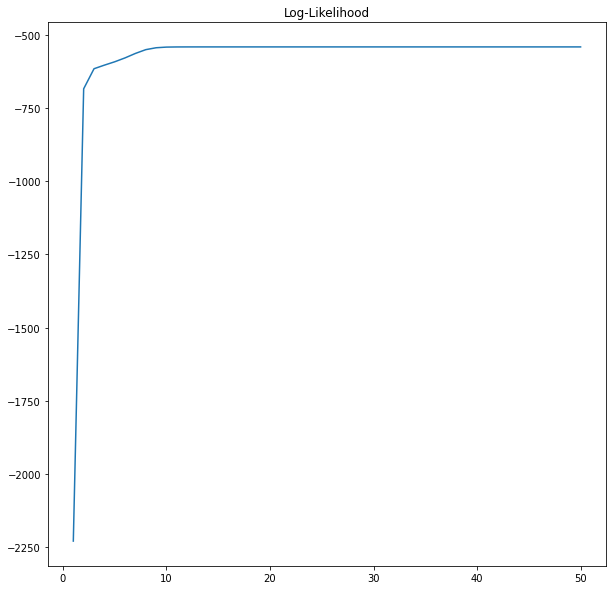

In [0]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()

**Visualizzazione dei clusters e dei parametri della GGM**

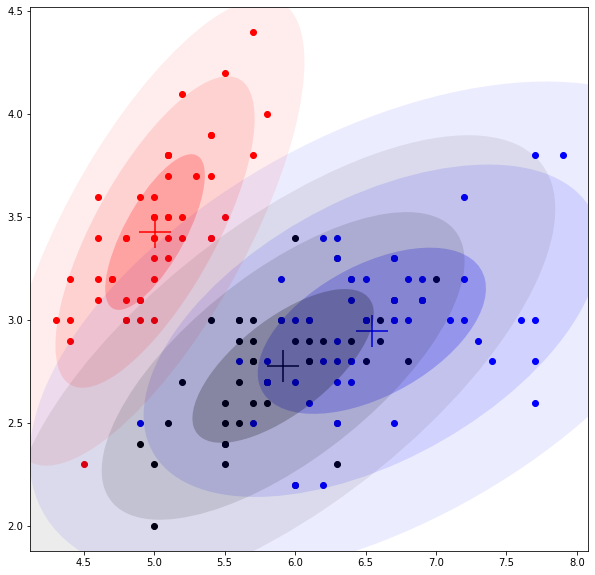

In [0]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, history, scores)

NOTA: aprendo il file __gmm.gif__  è possibile visulizzare un animazione di come la stima dei cluster migliori ad ogni iterazione.

## Implementazione usando scikit-learn ##

quella da usare in pratica ...

In [0]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)

print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
print('Scores by sklearn:\n', gmm_scores[0:20])
print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

Means by sklearn:
 [[5.006      3.428      1.462      0.246     ]
 [5.91697517 2.77803998 4.20523542 1.29841561]
 [6.54632887 2.94943079 5.4834877  1.98716063]]
Means by our implementation:
 [[6.54454865 2.94866115 5.47955343 1.98460495]
 [5.006      3.428      1.462      0.246     ]
 [5.91496959 2.77784365 4.20155323 1.29696685]]
Scores by sklearn:
 [ 1.57050082  0.73787138  1.14436656  0.92913238  1.411028   -0.09451903
  0.05266884  1.62442195  0.27082378  0.16706624  0.83489877  0.77168582
  0.29597841 -1.79224582 -3.41557928 -2.10529279 -1.12995447  1.47503579
 -0.84612536  0.97699215]
Scores by our implementation:
 [ 1.57057947  0.73793642  1.14444614  0.92920539  1.41110417 -0.09448868
  0.05268031  1.62449505  0.27090462  0.16702226  0.83494742  0.77171947
  0.29597776 -1.79222469 -3.41562626 -2.1052825  -1.1300608   1.47509939
 -0.84608424  0.9770596 ]


## Esercizi: ##

* provare a cambiare il numero di cluster nella GMM da 1 a 10 ... la logLikelihood fornisce informazioni sul valore giusto del numeori di cluster (3)? 

* inizializzando la GMM con centroidi random invece che con i valori ottenuti da k-means si ottengono prestazioni altrettando buone?

* come si ottengono predizione di classe e probabilità di classe per la GMM in scikit-learn? Dividete il campione in 80% trainign e 20% test, addestrate la GMM con il training set e predicete label di classe e probabilità di classe per gli eventi di test ... quale è l'accuracy ottenuta? 

#**GMM con numero dei clusters variabile**

In questa fase vogliamo studiare le variazioni nella log-likelihood al variare del numero di clusters impostato per l'algoritmo. Ci poniamo come obiettivo il capire se la log-likelihood fornisca informazioni sul numero giusto dei clusters.

Utilizziamo dunque l'algoritmo GMM implementato manualmente e grafichiamo la log-likelihood con un numero di clusters variabile da 1 a 10.

Epoch:  1 Likelihood:  -964.0117933921914
Epoch:  2 Likelihood:  -379.9146301222695
Epoch:  3 Likelihood:  -379.9146301222695
Epoch:  4 Likelihood:  -379.9146301222695
Epoch:  5 Likelihood:  -379.9146301222695
Epoch:  6 Likelihood:  -379.9146301222695
Epoch:  7 Likelihood:  -379.9146301222695
Epoch:  8 Likelihood:  -379.9146301222695
Epoch:  9 Likelihood:  -379.9146301222695
Epoch:  10 Likelihood:  -379.9146301222695
Epoch:  11 Likelihood:  -379.9146301222695
Epoch:  12 Likelihood:  -379.9146301222695
Epoch:  13 Likelihood:  -379.9146301222695
Epoch:  14 Likelihood:  -379.9146301222695
Epoch:  15 Likelihood:  -379.9146301222695
Epoch:  16 Likelihood:  -379.9146301222695
Epoch:  17 Likelihood:  -379.9146301222695
Epoch:  18 Likelihood:  -379.9146301222695
Epoch:  19 Likelihood:  -379.9146301222695
Epoch:  20 Likelihood:  -379.9146301222695
Epoch:  21 Likelihood:  -379.9146301222695
Epoch:  22 Likelihood:  -379.9146301222695
Epoch:  23 Likelihood:  -379.9146301222695
Epoch:  24 Likelihoo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


Epoch:  1 Likelihood:  -4440.581116947493
Epoch:  2 Likelihood:  -1354.775617733792
Epoch:  3 Likelihood:  -1141.5756441155866
Epoch:  4 Likelihood:  -1079.3272063727684
Epoch:  5 Likelihood:  -1013.5505880536825
Epoch:  6 Likelihood:  -952.1695324873547
Epoch:  7 Likelihood:  -909.7995481752259
Epoch:  8 Likelihood:  -883.5767178014391
Epoch:  9 Likelihood:  -864.4615919095459
Epoch:  10 Likelihood:  -842.2350306836645
Epoch:  11 Likelihood:  -825.8887844507694
Epoch:  12 Likelihood:  -820.674833795035
Epoch:  13 Likelihood:  -817.3317842901445
Epoch:  14 Likelihood:  -814.6259001393219
Epoch:  15 Likelihood:  -812.3826273737823
Epoch:  16 Likelihood:  -810.5406889864801
Epoch:  17 Likelihood:  -809.0944013466005
Epoch:  18 Likelihood:  -808.02850087772
Epoch:  19 Likelihood:  -807.2874038515677
Epoch:  20 Likelihood:  -806.7831433188971
Epoch:  21 Likelihood:  -806.4295202592743
Epoch:  22 Likelihood:  -806.1655738516805
Epoch:  23 Likelihood:  -805.9560522508876
Epoch:  24 Likelihoo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
No handles with labels found to put in legend.


Epoch:  48 Likelihood:  -804.5767096665782
Epoch:  49 Likelihood:  -804.5480266087951
Epoch:  50 Likelihood:  -804.516861570756


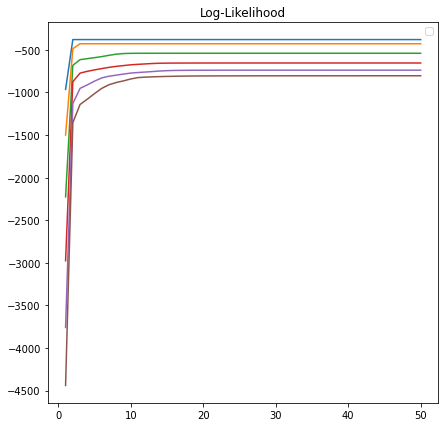

In [0]:
clus = range(1,7,1)
plt.figure(figsize=(7, 7))
plt.title('Log-Likelihood')
n_epochs = 50

for cluster_index in clus:
  clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, cluster_index, n_epochs)
  plt.plot(np.arange(1, n_epochs + 1), likelihoods)

plt.legend()
plt.show()

Osserviamo che la log-likelihood non dà alcuna indicazione sul numero di clusters. L'unico cambiamento apprezzabile, infatti, è nell'abbassamento del plateau della curva al crescere del numero di clusters.

#**Inizializzazione con centroidi casuali**

Passiamo ora allo studio della dipendenza della performance dell'algoritmo dalla posizione dei centroidi di partenza. Confrontiamo quindi i risultati ottenuti dall'algoritmo (implementato tramite la libreria scikit-learn) utilizzando dei centroidi casuali in un caso e quelli individuati da K-means nell'altro.

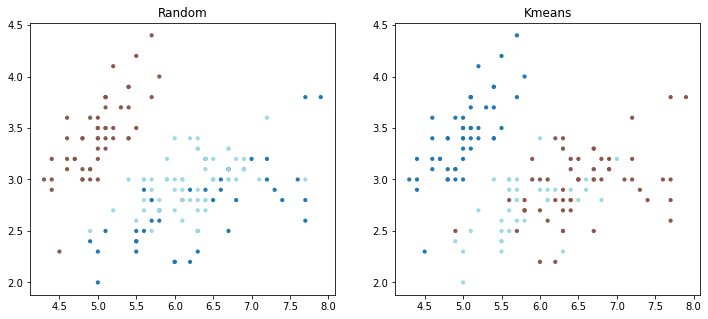

In [0]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

gmm = GaussianMixture(n_components=n_clusters, max_iter=50, init_params='random')
gmm.fit(X)
gmm_scores = gmm.score_samples(X)
gmm_predictions = gmm.predict(X)

gmmk = GaussianMixture(n_components=n_clusters, max_iter=50, init_params='kmeans').fit(X)
gmmk_scores = gmmk.score_samples(X)
gmmk_predictions = gmmk.predict(X)

ax1 = plt.subplot(1,2,1)
ax1 = plt.title('Random')
ax1 = plt.scatter(X[:,0], X[:,1], s=10, c=gmm_predictions, cmap='tab20')

ax2 = plt.subplot(1,2,2)
ax2 = plt.title('Kmeans')
ax2 = plt.scatter(X[:,0], X[:,1], s=10, c=gmmk_predictions, cmap='tab20')


In [0]:
Y = iris.target

k_means_acc = metrics.adjusted_rand_score(Y, gmmk_predictions)
random_acc = metrics.adjusted_rand_score(Y, gmm_predictions)
print ("Accuracy with k-means centroids: %.4f"%k_means_acc, "\nAccuracy with random centroids: %.4f"%random_acc)

Accuracy with k-means centroids: 0.9039 
Accuracy with random centroids: 0.5688


Come prevedibile, se iteriamo più volte l'algoritmo, osserviamo che l'accuracy relativa all'algoritmo inizializzato con centroidi casuali è molto variabile. Non abbiamo modo di prevedere se il risultato sarà migliore di quello ottenuto con dei centroidi iniziali selezionati da K-means, che comunque è già di qualità elevata. Concludiamo allora che l'utilizzo di un'inizializzazione non casuale, ma scelta attraverso K-means, sia preferibile, in quanto garantisce un'accuracy alta e stabile.

#**Predizione e probabilità di classe in SciKitLearn**

Come ultimo studio ci proponiamo di addestrare la GMM implementata tramite scikit-learn per predire le label e le probabilità di classe di un campione di test.

In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
train_to_test_ratio=0.8 # training samples
n_clusters=3

X = iris.data
Y = iris.target

In [0]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
gmm = GaussianMixture(n_components=n_clusters, max_iter=50, init_params='kmeans')
gmm.fit(x_train)
gmm_scores = gmm.score_samples(x_train)

gmm_pred_train = gmm.predict(x_train)

gmm_pred_test = gmm.predict(x_test)

data=pd.DataFrame(x_train)
data['true labels']=y_train
data['predicted labels']=gmm_pred_train

data_test=pd.DataFrame(x_test)
data_test['true labels']=y_test
data_test['predicted labels']=gmm_pred_test


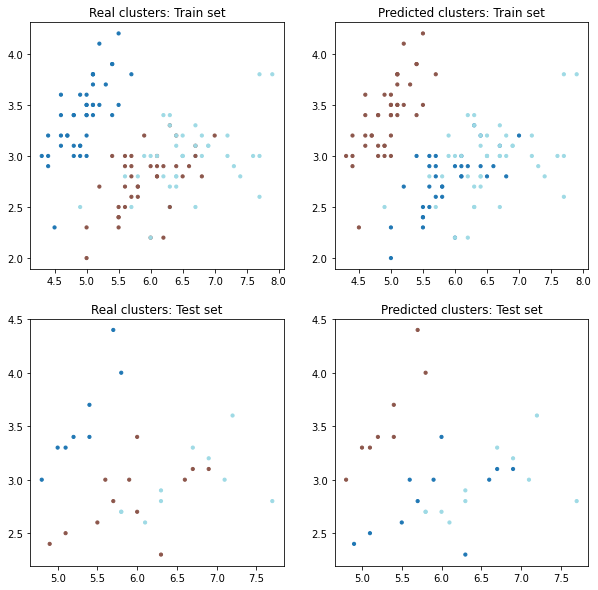

In [0]:
plt.close()

plt.figure(figsize=(10,10))
ax1 = plt.subplot(2, 2, 1)
ax1 = plt.title('Real clusters: Train set')
ax1 = plt.scatter(x_train[:, 0], x_train[:, 1], s=10, c=y_train,cmap = 'tab20')
ax2 = plt.subplot(2, 2, 2)
ax2 = plt.title('Predicted clusters: Train set')
ax2 = plt.scatter(x_train[:, 0], x_train[:, 1], s=10, c=gmm_pred_train,cmap = 'tab20')
ax3 = plt.subplot(2, 2, 3)
ax3 = plt.title('Real clusters: Test set')
ax3 = plt.scatter(x_test[:, 0], x_test[:, 1], s=10, c=y_test,cmap = 'tab20')
ax4 = plt.subplot(2, 2, 4)
ax4 = plt.title('Predicted clusters: Test set')
ax4 = plt.scatter(x_test[:, 0], x_test[:, 1], s=10, c=gmm_pred_test,cmap = 'tab20')

plt.show()

In [0]:
train_acc = metrics.adjusted_rand_score(y_train, gmm_pred_train)
test_acc = metrics.adjusted_rand_score(y_test, gmm_pred_test)
print ("Accuracy on the train set: %.4f"%train_acc, "\nAccuracy on the test set: %.4f"%test_acc)

Accuracy on the train set: 0.9062 
Accuracy on the test set: 0.8888


Osserviamo che i clusters ottenuti rispecchiano bene quelli reali. A conferma di ciò, le accuracies ottenute per i campioni di training e di test sono molto elevate. Sebbene l'utilizzo di un dataset di dimensioni modeste possa influire sui risultati ottenuti, possiamo ritenerci soddisfatti delle prestazioni dell'algoritmo.

Concludiamo riportando le probabilità di classe ottenute con l'algoritmo.

In [0]:
#Mostriamo solo gli ultimi 5 eventi, a scopo illustrativo
gmm_pred_probs_train = gmm.predict_proba(x_train)
gmm_pred_probs_test = gmm.predict_proba(x_test)
print("Probability for each cluster, train set:\n",gmm_pred_probs_train[-5:],"\n\nProbability for each cluster, test set:\n",gmm_pred_probs_test[-5:])


Probability for each cluster, train set:
 [[1.00000000e+000 4.51464558e-116 6.63445827e-014]
 [1.66059621e-003 8.01766120e-077 9.98339404e-001]
 [1.32379264e-039 1.00000000e+000 2.27147413e-041]
 [3.30883604e-005 1.75397281e-040 9.99966912e-001]
 [1.54224546e-002 2.21565831e-065 9.84577545e-001]] 

Probability for each cluster, test set:
 [[1.89046185e-39 1.00000000e+00 3.72181784e-39]
 [9.61571382e-06 2.88283719e-36 9.99990384e-01]
 [1.08729231e-02 1.67362127e-71 9.89127077e-01]
 [1.93672317e-02 8.31523728e-61 9.80632768e-01]
 [4.63071162e-01 2.08880897e-87 5.36928838e-01]]
